#### Notebook that prepares data for the SFI Masterclass

https://www.kaggle.com/mlg-ulb/creditcardfraud

Writes to /data (observing that max. size for data in Github is ~100 MB)

In [58]:
import os
import sys
import pandas as pd
import random
import numpy as np

In [44]:
df = pd.read_csv(r'../bigdata/creditcard.csv')

In [45]:
df = df.drop(columns=['Time'])

In [46]:
# downsample and obfuscate the data
df_sampled = df.sample(100000).reset_index(drop=True)


In [93]:
df_sampled = df_sampled.astype('float16')

In [47]:
original_column_names = list(df_sampled.columns)
new_v_columns = [col for col in df_sampled.columns if 'V' in col]
random.seed(2)
random.shuffle(new_v_columns)
df_sampled = df[new_v_columns + original_column_names[-2:]]
df_sampled.columns = original_column_names

In [96]:
X = df_sampled.iloc[:, :-1]
y = df_sampled.Class.astype(int)

In [95]:
X.to_csv(r'../data/X.csv.zip', compression="zip")
y.to_csv(r'../data/y.csv.zip', compression="zip")

In [71]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture


In [54]:
sys.path.append(r'../.')
!pip install seaborn
from outlierutils import plot_top_N, plot_outlier_scores

     |████████████████████████████████| 285 kB 2.2 MB/s eta 0:00:01
You should consider upgrading via the '/Users/ernstoldenhof/Projects/MasterclassSFI2021/venv/bin/python -m pip install --upgrade pip' command.


In [97]:
cov_ = EmpiricalCovariance().fit(X)
# cov_ = MinCovDet().fit(X) # Robust estimation
mahalonobis_scores = cov_.mahalanobis(X)


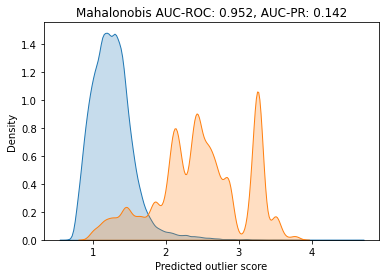

In [98]:
mahalonobis_scores = np.log10(mahalonobis_scores)
res = plot_outlier_scores(y.values, mahalonobis_scores, bw=0.1, title='Mahalonobis')

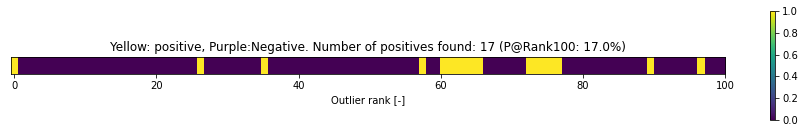

In [83]:
res = plot_top_N(y.values, mahalonobis_scores, N=100)

In [72]:
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=1) # try also spherical
gmm.fit(X, )
gmm_scores = - gmm.score_samples(X)

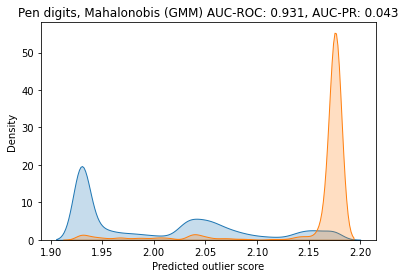

In [86]:
# gmm_scores = np.clip(gmm_scores, -15, 50)
res = plot_outlier_scores(y.values, np.log10(gmm_scores+100), bw=0.1, title='Pen digits, Mahalonobis (GMM)')

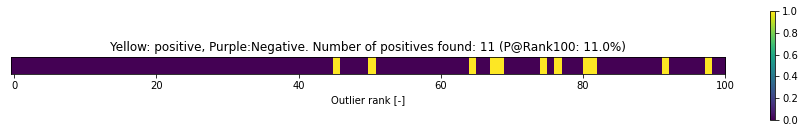

In [78]:
res = plot_top_N(y.values, gmm_scores, N=100)